Layer normalization, [Paper](https://arxiv.org/abs/1607.06450)

This is just a copy-and-paste of my implementation of batch norm. The only difference between layer normalization and batch normalization is the dimension which is normalized. In batch norm, its normalized along the batch dimension whilst in layer norm its normalized along the channel dimension
here is the batch norm [Paper](https://arxiv.org/pdf/1502.03167) to make comparisons 

So,

```python

# in batch norm
v = emb @ W1 + b1
mean = v.mean(dim=0, keepdim=True)
var = v.var(dim=0, keepdim=True)
pre_tanh = (v - mean) / (var + 1e-5).sqrt()
pre_tanh = bn_gain * pre_tanh + bn_bias
h = torch.tanh(pre_tanh) 


# whilst in layer norm
v = emb @ W1 + b1
mean = v.mean(dim=1, keepdim=True) # the only diffference is the dimension
var = v.var(dim=1, keepdim=True) # here too
pre_tanh = (v - mean) / (var + 1e-5).sqrt()
pre_tanh = bn_gain * pre_tanh + bn_bias
h = torch.tanh(pre_tanh)
```


In [1]:
import requests
import os

def download_file(url, file_path, replace=False):
    # Construct the full path to the file
    full_path = os.path.join(file_path)

    # Check if the file already exists and remove it if necessary
    if os.path.exists(full_path):
        if not replace:
            print("file already exists")
            return
        os.remove(full_path)
        print(f"File {full_path} already exists. Replacing it.")

    try:
        # Download the file
        response = requests.get(url, allow_redirects=True)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Save the file
        with open(full_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as {full_path}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Example usage
url = 'https://raw.githubusercontent.com/amar-jay/karpathy/main/makemore/assets/names.txt'
file_path = os.path.join(os.getcwd(), "..", "..", "data", "baby_names.txt")

download_file(url, file_path)

file already exists


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline
g = torch.Generator().manual_seed(21012003) # for reproducibility

torch.__version__

with open(file_path, "r") as f:
    words = f.read().splitlines()
    words = [word.strip() for word in words] # get rid of any trailing spaces
    words = [w for w in words if w] # get rid of any empty strings
    names = sorted(words, key=lambda x: random.random())

min_chars = min(len(v) for v in names)
max_chars = max(len(v) for v in names)
chars = sorted(list(set("".join(names))))

# in replacement of the start and end token. Every name should end with a period. and there should be no start token to begin a sequence
chars = ['.'] + chars
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

# adding end token to each name
names = [list(name) + ['.'] for name in names]

names:  ['chimaobi', 'beau', 'elayna', 'azure', 'chrissy']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 2)


In [3]:
# hyper-params
n_embd = 10  # intermediate weight size
block_size  = 3 # context length
n_embd2 = 200 # intermediate weight size
lr = 0.05 # determined based on graph
decay_rate = 0.01 # learning rate decay
batch_size = 64

In [4]:
# build_dset basically builds a rolling window on the dataset based on the context length.
def get_dataset(dset, ctxt_len):
    X, Y = [], []
    for name in dset:
        context  = [0] * ctxt_len
        for ch in name:
            ix = atoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itoa[i] for i in context), '--->', itoa[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
    
# train-test split(80, 10, 10)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_train, Y_train = get_dataset(names[:n1], block_size)
X_val, Y_val = get_dataset(names[n1:n2], block_size)
X_test, Y_test = get_dataset(names[n2:], block_size)

for c, d in zip(X_train[:5], Y_train[:5]):
    print(''.join(itoa[i.item()] for i in c), "=>", itoa[d.item()])

... => c
..c => h
.ch => i
chi => m
him => a


In [5]:
# TRAINING WITHOUT BATCH NORM
# parameters
C_ = torch.randn((27, n_embd), generator=g) 
W1_ = torch.randn((block_size * n_embd, n_embd2), generator=g) # hidden layer
b1_ = torch.randn(n_embd2, generator=g)
W2_ = torch.randn((n_embd2, 27), generator=g) # output layer
b2_ = torch.zeros(27,)

params_ = [C_, W1_, b1_, W2_, b2_]

for p in params_:
    p.requires_grad = True # autograd should record operations
    
max_steps = 100000
losses_ = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb_ = C_[X_train[ix]].view(-1, block_size * n_embd)
    v_ = emb_ @ W1_ + b1_

    h_ = torch.tanh(v_) # intermediate layer
    logits = h_ @ W2_ + b2_
        
    loss_ = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss_.item())
    
    # backward pass
    for p in params_:
        p.grad = None
    loss_.backward()

    # update
    lri_ = lr if max_steps > 10000 else decay_rate
    for p in params_:
        p.data += - lri_ * p.grad 
    losses_.append(loss_.item())

( 0.0 %) loss = 93.54696655273438
( 10.0 %) loss = 2.308579206466675
( 20.0 %) loss = 2.5328309535980225
( 30.0 %) loss = 2.4881129264831543
( 40.0 %) loss = 2.322882890701294
( 50.0 %) loss = 2.2069520950317383
( 60.0 %) loss = 2.536142349243164
( 70.0 %) loss = 2.210566997528076
( 80.0 %) loss = 2.129309892654419
( 90.0 %) loss = 2.1909055709838867


In [6]:
# TRAINING WITH BATCH NORM
# parameters
C = torch.randn((27, n_embd), generator=g) 
W1 = torch.randn((block_size * n_embd, n_embd2), generator=g) # hidden layer
b1 = torch.randn(n_embd2, generator=g) 
W2 = torch.randn((n_embd2, 27), generator=g) # output layer
b2 = torch.zeros(27,)

#buffers
bn_gain = torch.ones((1, n_embd2))
bn_bias = torch.zeros((1, n_embd2))

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True # autograd should record operations
    
max_steps = 100000
losses = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, block_size * n_embd)
    v = emb @ W1 + b1

    # batch norm
    mean = v.mean(dim=1, keepdim=True)
    var = v.var(dim=1, keepdim=True)
    pre_tanh = (v - mean) / (var + 1e-5).sqrt()
    pre_tanh = bn_gain * pre_tanh + bn_bias

    h = torch.tanh(pre_tanh) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lri = lr if max_steps > 10000 else decay_rate
    for p in params:
        p.data += - lri * p.grad 
    losses.append(loss.item())

( 0.0 %) loss = 22.44281768798828
( 10.0 %) loss = 2.3408095836639404
( 20.0 %) loss = 2.470330238342285
( 30.0 %) loss = 2.320587635040283
( 40.0 %) loss = 2.2915070056915283
( 50.0 %) loss = 2.187016248703003
( 60.0 %) loss = 2.332878351211548
( 70.0 %) loss = 2.6760916709899902
( 80.0 %) loss = 2.4937825202941895
( 90.0 %) loss = 2.4457666873931885


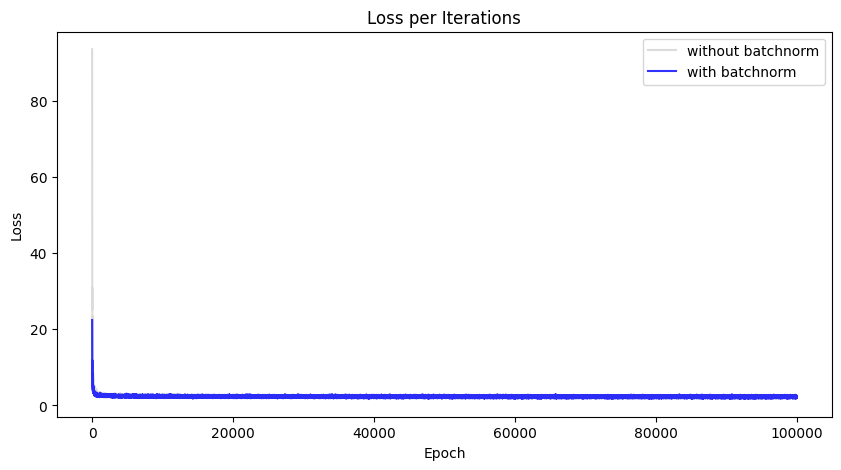

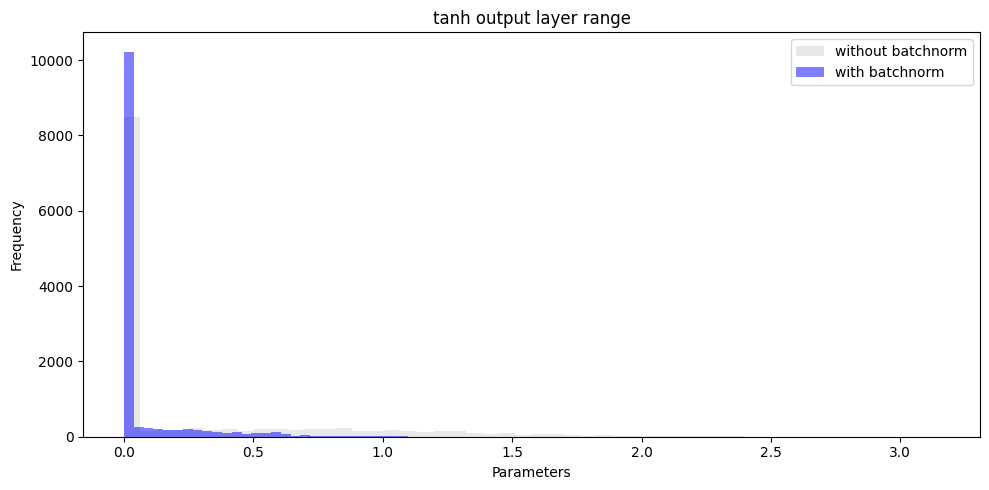

NameError: name 'v_' is not defined

<Figure size 1000x500 with 0 Axes>

In [7]:
with torch.no_grad():
    # Plot the graphs
    # basically gradient descent is equal in training. However parameter distribution varies. There's exploding and vanishing gradients in unnormalized one
    plt.figure(figsize=(10, 5))
    plt.plot(losses_, label='without batchnorm', alpha=0.8, color='lightgray')
    plt.plot(losses, label='with batchnorm', alpha=0.8,  color='blue',)

    plt.title("Loss per Iterations")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    plt.figure(figsize=(10, 5))
    plt.hist(h_.view(-1), bins=50, alpha=0.5, label='without batchnorm', color="lightgray")
    plt.hist(h.view(-1), bins=50, alpha=0.5, label='with batchnorm', color="blue")

    plt.title("tanh output layer range")
    plt.xlabel('Parameters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(v_.view(-1), bins=50, alpha=0.5, label='without batchnorm', color="lightgray")
    plt.hist(v.view(-1), bins=50, alpha=0.5, label='with batchnorm', color="blue")

    plt.title("tanh input layer range")
    plt.xlabel('Parameters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
@torch.no_grad()
def loss(x, y, _params):
    emb = _params[0][x].view(-1, 30)
    v = emb @ _params[1] + _params[2]
    h = torch.tanh(v) # intermediate layer
    logits = h @ _params[3] + _params[4]
    loss = F.cross_entropy(logits, y)
    return loss.item()

print("With normalization")
params = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print("training loss: ", loss(X_train, Y_train, params))
print("val loss: ", loss(X_val, Y_val, params))
print("test loss: ", loss(X_test, Y_test, params))
print("-"*8)
params_ = [C_, W1_, b1_, W2_, b2_]
print("Without normalization")
print("training loss: ", loss(X_train, Y_train, params_))
print("val loss: ", loss(X_val, Y_val, params_))
print("test loss: ", loss(X_test, Y_test, params_))

In [ ]:
# inference its totally unneccessary but I thought it might be cool to add
import time

def inference():
    C, W1, b1, W2, b2 = params[:5] 
    emb = C[torch.tensor(context)].view(-1, block_size * n_embd)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # print(probs)
    ix = torch.multinomial(probs, num_samples=1, generator=g)
    
with torch.no_grad():
    generated_names = []
    print("generating...")
    start_time = time.time()
    while True:
        out = []
        probs = None
        context  = [0] * block_size
        while True:
            ix = inference(params) 
            context = context[1:] + [ix]
            out.append(ix)
            
            if ix == 0:
                break

        word = ''.join(itoa[i.item()] for i in out)
        if nnl(word) < 1.5 and len(word) > 3 and word not in generated_names:
            print("+ valid word: ", word)
            generated_names.append(word) 
        if len(generated_names) == 10:
            break
    duration = time.time() - start_time
    print("duration: ", duration)

The effect is more noticable when there are more layers and the netowrks goes nire deeoer, That;s when the iissue arrises but now there's nothing much 